# Statistik-Projekt HS25 – A/B-Testing & Effektgrössen
## Notebook 9: Zürich HB vs. St. Gallen – Vergleich der Ankunftsverspätungen

### Ziel
Wir untersuchen, ob Züge am **Zürich Hauptbahnhof (ZH HB)** systematisch höhere Verspätungen aufweisen als am **Bahnhof St. Gallen (SG)**.

### Fragen:
1. Gibt es einen statistisch signifikanten Unterschied in den Verspätungen?
2. Wie gross ist der Unterschied (Effektgrösse)?
3. Können wir den Unterschied mittels **Bootstrap-Konfidenzintervallen** quantifizieren?
4. Ist der Unterschied im echten Betrieb relevant?

### Methoden:
- Zweistichproben-Vergleich:
  - **Welch’s t-Test** (robust gegenüber ungleichen Varianzen)
  - **Mann–Whitney-U-Test** (nichtparametrisch)
- **Effektgrössen**:
  - Cohen’s d
  - Rank-biserial correlation
- **Bootstrap (10'000 Samples)** für:
  - Unterschied der Mittelwerte
  - Unterschied der Mediane


## Imports und Daten laden

In [2]:
import polars as pl
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 5)

DATA_PATH = "../data/processed/istdata_trains_clean.parquet"

df = pl.read_parquet(DATA_PATH)

df = (
    df
    .select(["HALTESTELLEN_NAME", "delay_arrival_s"])
    .with_columns((pl.col("delay_arrival_s") / 60).alias("delay_min"))
    .drop_nulls()
)

# Zwei Bahnhöfe auswählen
df_ab = df.filter(
    pl.col("HALTESTELLEN_NAME").is_in(["Zürich HB", "St. Gallen"])
)

df_ab = df_ab.to_pandas()  # Wir brauchen pandas für die Stats-Modelle

df_ab.head()

,HALTESTELLEN_NAME,delay_arrival_s,delay_min
0,Zürich HB,257.0,4.283333
1,Zürich HB,12.0,0.200000
2,Zürich HB,106.0,1.766667
3,Zürich HB,62.0,1.033333
4,Zürich HB,73.0,1.216667


## Basis-Werte

In [3]:
df_ab.groupby("HALTESTELLEN_NAME")["delay_min"].describe()

,count,mean,std,min,25%,50%,75%,max
HALTESTELLEN_NAME,,,,,,,,
St. Gallen,18772.0,0.800507,3.054944,-55.783333,-0.166667,0.483333,1.216667,73.916667
Zürich HB,66865.0,1.033421,3.592972,-30.066667,0.183333,0.550000,1.150000,267.500000


## Visualisierung der Verteilungen

/var/folders/t5/b1vkfs5n09s2lv5t8w7nl8r00000gn/T/ipykernel_27520/3670553260.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


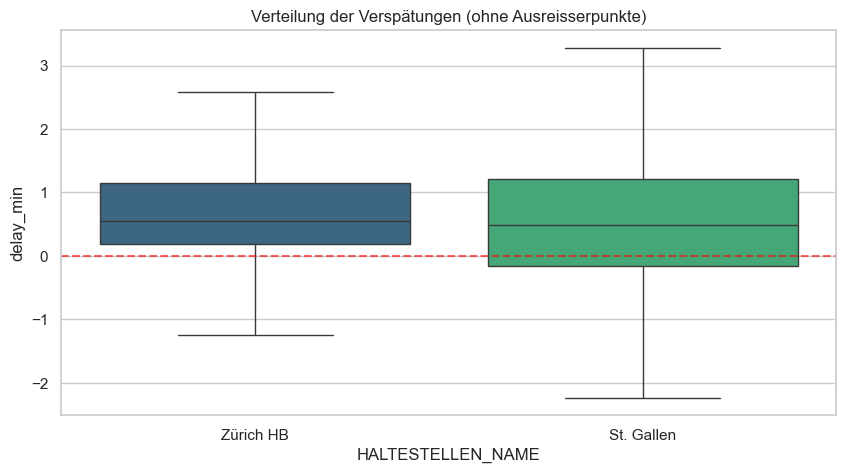

HALTESTELLEN_NAME
St. Gallen    0.069518
Zürich HB     0.079728
Name: delay_min, dtype: float64


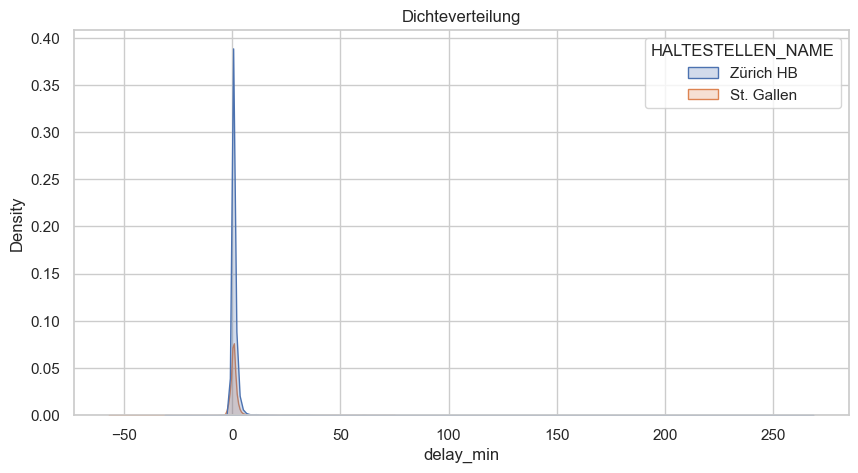

In [7]:
# Boxplot ohne Outlier-Punkte
sns.boxplot(
    data=df_ab, x="HALTESTELLEN_NAME", y="delay_min",
    palette="viridis", showfliers=False
)
plt.axhline(0, color="red", linestyle="--", alpha=0.6)
plt.title("Verteilung der Verspätungen (ohne Ausreisserpunkte)")
plt.show()


print(df_ab.groupby("HALTESTELLEN_NAME")["delay_min"].apply(outlier_rate))

sns.kdeplot(data=df_ab, x="delay_min", hue="HALTESTELLEN_NAME", fill=True)
plt.title("Dichteverteilung")
plt.show()

## Welch t-Test

In [8]:
zh = df_ab[df_ab["HALTESTELLEN_NAME"] == "Zürich HB"]["delay_min"]
sg = df_ab[df_ab["HALTESTELLEN_NAME"] == "St. Gallen"]["delay_min"]

t_stat, p_val = stats.ttest_ind(zh, sg, equal_var=False)

print("=== Welch t-Test ===")
print(f"t-Statistik: {t_stat:.3f}")
print(f"p-Wert:      {p_val:.4e}")

=== Welch t-Test ===
t-Statistik: 8.865
p-Wert:      7.9754e-19


## Mann-Whitney-U (nichtparametrisch)

In [9]:
u_stat, u_p = stats.mannwhitneyu(zh, sg, alternative="two-sided")

print("=== Mann–Whitney-U ===")
print(f"U-Statistik: {u_stat:.3f}")
print(f"p-Wert:      {u_p:.4e}")

=== Mann–Whitney-U ===
U-Statistik: 677399192.000
p-Wert:      3.4644e-62


## Effektgrössen

In [ ]:
def cohens_d(x, y):
    nx, ny = len(x), len(y)
    pooled_sd = np.sqrt(((nx-1)*np.var(x) + (ny-1)*np.var(y)) / (nx + ny - 2))
    return (np.mean(x) - np.mean(y)) / pooled_sd

d = cohens_d(zh, sg)

print("=== Effektgrösse: Cohen’s d ===")
print(f"d = {d:.3f}")

def rank_biserial(x, y):
    u_stat, _ = stats.mannwhitneyu(x, y, alternative="two-sided")
    n1, n2 = len(x), len(y)
    return 1 - (2 * u_stat) / (n1 * n2)

rb = rank_biserial(zh, sg)

print("=== Effektgrösse: Rank-Biserial Correlation ===")
print(f"r_bc = {rb:.3f}")

=== Effektgröße: Cohen’s d ===
d = 0.067
=== Effektgröße: Rank-Biserial Correlation ===
r_bc = -0.079


## Bootstrap (10'000 Iterationen) & Bootstrap-Konfidenzintervalle

=== Bootstrap CI (Mittelwertdifferenz) ===
[0.18105357 0.28488966]

=== Bootstrap CI (Mediandifferenz) ===
[0.05       0.06666667]


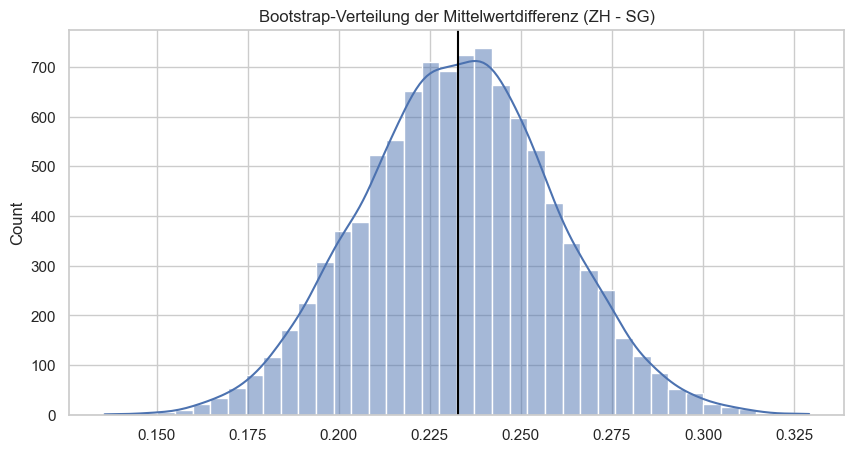

In [11]:
N_BOOT = 10_000

boot_mean = []
boot_median = []

for _ in range(N_BOOT):
    zh_s = np.random.choice(zh, size=len(zh), replace=True)
    sg_s = np.random.choice(sg, size=len(sg), replace=True)

    boot_mean.append(np.mean(zh_s) - np.mean(sg_s))
    boot_median.append(np.median(zh_s) - np.median(sg_s))

boot_mean = np.array(boot_mean)
boot_median = np.array(boot_median)

def ci(x, alpha=0.05):
    return np.quantile(x, [alpha/2, 1-alpha/2])

print("=== Bootstrap CI (Mittelwertdifferenz) ===")
print(ci(boot_mean))

print("\n=== Bootstrap CI (Mediandifferenz) ===")
print(ci(boot_median))

sns.histplot(boot_mean, bins=40, kde=True)
plt.axvline(np.mean(boot_mean), color="black")
plt.title("Bootstrap-Verteilung der Mittelwertdifferenz (ZH - SG)")
plt.show()

### Interpretation & Fazit

Unsere Analyse der Ankunftsverspätungen am Zürich Hauptbahnhof und am Bahnhof St. Gallen zeigt, dass Züge in Zürich im Durchschnitt leicht höhere Verspätungen aufweisen. Der Mittelwert der Verspätungen liegt in Zürich bei 1.03 Minuten, in St. Gallen bei 0.80 Minuten, was einer Differenz von rund 0.23 Minuten (≈ 14 Sekunden) entspricht. Auch der Median ist in Zürich geringfügig höher (0.55 Minuten gegenüber 0.48 Minuten), mit einer Differenz von 0.07 Minuten.

Sowohl der parametrische Welch-t-Test als auch der nichtparametrische Mann–Whitney-U-Test liefern extrem kleine p-Werte, was klar auf einen statistisch signifikanten Unterschied zwischen den beiden Verteilungen hinweist. Diese hohe Signifikanz ist jedoch vor allem auf die sehr grossen Stichproben zurückzuführen und bedeutet nicht automatisch einen starken praktischen Effekt.

Tatsächlich bleibt die praktische Relevanz des Unterschieds gering. Die Effektgrössen sind sehr klein: Cohen’s d beträgt 0.067, was einem vernachlässigbaren Effekt entspricht, und auch die rank-biseriale Korrelation von −0.079 deutet lediglich auf einen minimalen Vorteil von St. Gallen hinsichtlich der Pünktlichkeit hin.

Die Bootstrap-Analyse mit 10’000 Iterationen bestätigt diese Einschätzung. Die 95 %-Konfidenzintervalle für die Mittelwert- und Median-Differenzen liegen vollständig oberhalb von null, was die Richtung des Effekts (höhere Verspätungen in Zürich) robust absichert. Gleichzeitig zeigen die engen Intervalle, dass der Effekt zwar stabil, aber klein ist. Da das Bootstrap-Verfahren keine Normalverteilungsannahmen erfordert, ist dieses Ergebnis auch bei der stark rechtsschiefen Verteilung der Verspätungen verlässlich.

Insgesamt lässt sich festhalten, dass der Zürich Hauptbahnhof im Vergleich zu St. Gallen tendenziell leicht unpünktlicher ist. Der Unterschied ist statistisch klar nachweisbar, in seiner absoluten Grösse jedoch gering und dürfte sich im alltäglichen Reiseerlebnis nur begrenzt bemerkbar machen.